### EE 699 Next Generation Wireless Networks 
- Assignment 02 
- Author: $\text{Rishabh Pomaje}$ 
- Contact: 210020036@iitdh.ac.in

- In this notebook, we will simulate the following queues and compare our empirical findings with the analytic results.


1. $M/M/1$ Assumptions :
    - Poisson arrival process.
    - Exponential service times.
    - Single server.
    - Infinte buffer length.

In [1]:
# Dependencies :
import numpy as np
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'
# Set global parameters for publication quality
plt.rcParams.update({
    "text.usetex": True,            # Comment if TeX is unavailable on your machine 
    "font.family": "serif",          
})
import seaborn as sns 
sns.set_theme('paper')

In [2]:
# Global Definitions :
del_t = 10 ** -3            # in some time units

#### M/M/1 Queue

- Note: The arrival rate should be lesser than the departure rate to achieve equilibrium.

In [3]:
def m_m_1_q(simTime, arrRate, depRate):
    """ 
    Function to simulate an M/M/1 queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)

    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.   
    4. The individual "waiting times".(i.e., the time required to wait in the queue + the time to get served). 
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs)            
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                              # Tracks the customer being served by the server  

    for i in range(1, num_runs):
        # Flip a coin for arrival  
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # Flip a coin for departure only if there is an arrival
        if stateHistory[i-1] >= 1:
            isDeparture = np.random.binomial(1, min(1, depRate * del_t))
        else:
            isDeparture = 0

        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - isDeparture
        
        # Increment the timers for both arrival and departure
        arrTimer += del_t
        depTimer += del_t
        for idx in range(customerID, len(individualTimers)):
            individualTimers[idx] += del_t
        
        # If there was an arrival record the Inter-arrival time and clear the timer (restart)
        if isArrival:
            intArrTimes.append(arrTimer)
            arrTimer = 0
            individualTimers.append(0)
        # Similarly for departures
        if isDeparture:
            intDepTimes.append(depTimer)
            depTimer = 0 
            customerID += 1

    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [4]:
total_simul_time = 1000     # In common time units
arrival_rate = 6            # Number of arrivals per unit time
departure_rate = 10         # Number of departure per unit time
queue_history, arr_Times, dep_Times, ind_Times = m_m_1_q(total_simul_time, arrival_rate, departure_rate)

- Evolution of the state of the system

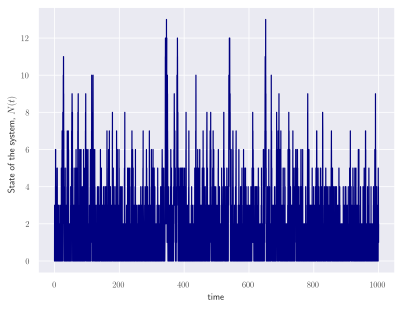

In [5]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

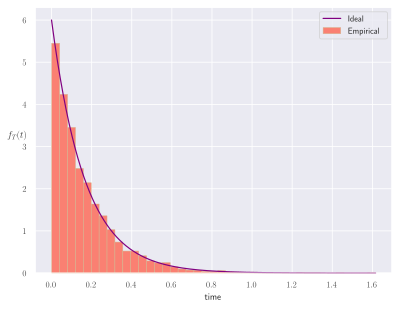

In [6]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, np.max(arr_Times), 1000)
ideal_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t, ideal_dist, color='purple', label='Ideal')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.legend()
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

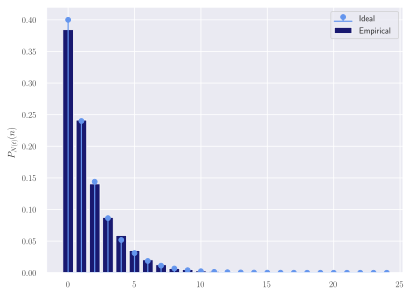

In [7]:
# Ideal PMF :: rho^n (1 - rho)
rho = arrival_rate / departure_rate
ideal_dist = []
for i in range(25):
    p_i = (rho ** i) * (1 - rho)
    ideal_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(ideal_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(r'$P_{N(t)}(n)$')
axes.legend()
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Average number of customers and Variance of number of customers

In [8]:
mean_empirical = np.mean(queue_history)
mean_ideal = rho / (1 - rho)

print(f'Expected mean value : {mean_ideal}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_ideal = rho / ((1 - rho) ** 2)

print(f'Expected variance : {var_ideal}\n -> Observed variance : {var_empirical}')

Expected mean value : 1.4999999999999998
 -> Observed mean value : 1.579388
Expected variance : 3.749999999999999
 -> Observed variance : 3.877023545456001


- Little's Law:
    - The average number of customers in a queue is equal to the product of the arrival rate times the average time spent in the queue.
    - $\bar{N} = \lambda \bar{\tau}$

In [9]:
print(f'Average number of customers in the queue = {mean_empirical}')
print(f'Product = {arrival_rate * np.mean(ind_Times)}')

Average number of customers in the queue = 1.579388
Product = 1.5588609968744835


#### M/M/1/N - _Finite buffer case_ 

In [10]:
def m_m_1_N_q(simTime, arrRate, depRate, N):
    """ 
    Function to simulate an M/M/1/N queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    4. N       = Buffer size
    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                              # Tracks the customer being served by the server  

    for i in range(1, num_runs):
        # Flip a coin for arrival  
        if stateHistory[i-1] >= N:
            isArrival = 0                       # Turn down the new arrival(s)
        else:
            isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # Flip a coin for departure only if there is atleast arrival
        if stateHistory[i-1] >= 1:
            isDeparture = np.random.binomial(1, min(1, depRate * del_t))
        else:
            isDeparture = 0

        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - isDeparture
        # Increment the timers for both arrival and departure
        arrTimer += del_t
        depTimer += del_t
        for idx in range(customerID, len(individualTimers)):
            individualTimers[idx] += del_t
        
        # If there was an arrival record the Inter-arrival time and clear the timer (restart)
        if isArrival:
            intArrTimes.append(arrTimer)
            arrTimer = 0
            individualTimers.append(0)
        # Similarly for departures
        if isDeparture:
            intDepTimes.append(depTimer)
            depTimer = 0 
            customerID += 1

    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [11]:
total_simul_time = 1000     # In common time units
arrival_rate = 6            # Number of arrivals per unit time
departure_rate = 10         # Number of departure per unit time
buffer_size = 10            # Buffer size of the queue
queue_history, arr_Times, dep_Times, ind_Times = m_m_1_N_q(total_simul_time, arrival_rate, departure_rate, buffer_size)

In [12]:
np.max(queue_history)

10.0

- Evolution of the state of the system

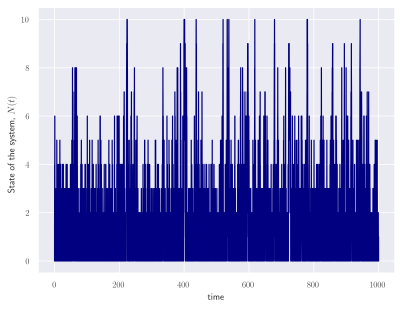

In [13]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

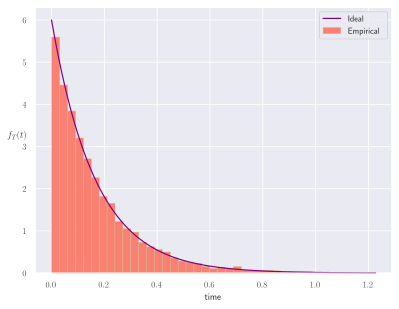

In [14]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, max(arr_Times), 1000)
ideal_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t, ideal_dist, color='purple', label='Ideal')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.legend()
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

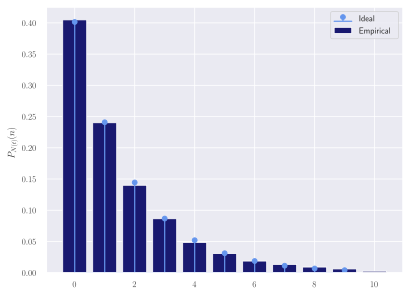

In [15]:
# Ideal PMF :: rho^n (1 - rho)
rho = arrival_rate / departure_rate
ideal_dist = []
for i in range(buffer_size):
    p_i = (1 - rho) * (rho ** i) / (1 - (rho ** (buffer_size+1)))
    ideal_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(ideal_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(r'$P_{N(t)}(n)$')
axes.legend()
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

#### M/M/$\infty$ - Infinite server system

In [16]:
def m_m_infinite_q(simTime, arrRate, depRate):
    """ 
    Function to simulate an M/M/infinite queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    
    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                                  # For tracking purposes
    activeIDs = []                                  # Will keep a record of customers currently at the server desk

    for i in range(1, num_runs):
        # Flip a coin for arrival
        # print(f'--------------Run Begin-------------------------')  
        # print(f'Previous state ={numCustomers[i-1]}')
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # print(f'isArrival = {isArrival}')
        # Flip a coin for departure only if there is atleast 1 customer
        if stateHistory[i-1] >= 1:
            # Create a departures list of indices
            isDepartures = [np.random.binomial(1, min(1, depRate * del_t)) for _ in range(int(stateHistory[i-1]))]
        else:
            isDepartures = []
        # print(f'isDepartures = {isDepartures}')
        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - np.sum(isDepartures)
        # print(f'Updated state = {numCustomers[i]}')
        # Increment the timers for both arrival and departure
        arrTimer += del_t
        for idx in activeIDs:
            individualTimers[idx] += del_t
        
        # Similarly for departures
        if isDepartures:
            intDepTimes.append(depTimer)
            depTimer = 0 
        # Keep only the unserved IDs in the active ID list
        tempIDs = [activeIDs[i] for i in range(len(isDepartures)) if isDepartures[i] == 0]
        activeIDs = tempIDs
        # print(f'activeIDs_post_dep = {activeIDs}')
        
        # If there was an arrival record the Inter-arrival time and clear the timer (restart)
        if isArrival:
            intArrTimes.append(arrTimer)
            arrTimer = 0
            individualTimers.append(0)
            activeIDs.append(customerID)
            customerID += 1 
        # print(f'activeIDs_post_arr = {activeIDs}')

        # print(f'--------------------Run End---------------------------')
    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [17]:
total_simul_time = 1000     # In common time units
arrival_rate = 25            # Number of arrivals per unit time
departure_rate = 10         # Number of departure per unit time
queue_history, arr_Times, dep_Times, ind_Times = m_m_infinite_q(total_simul_time, arrival_rate, departure_rate)

- Evolution of the state of the system

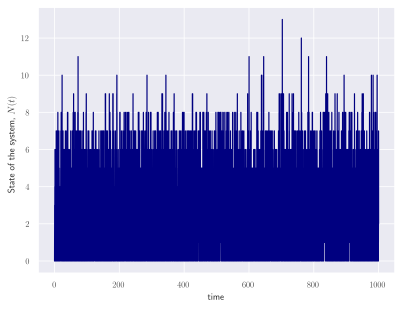

In [18]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

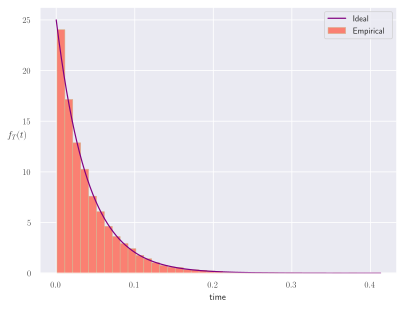

In [19]:
# Ideal PDF of Inter-arrival times :
t = np.linspace(0, np.max(arr_Times), 1000)
ideal_dist = arrival_rate * np.exp(-arrival_rate * t)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t, ideal_dist, color='purple', label='Ideal')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.legend()
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

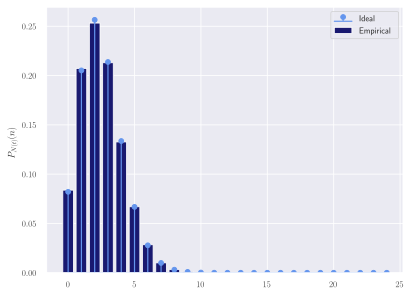

In [20]:
# Ideal PMF :: rho^n (1 - rho)
rho = arrival_rate / departure_rate
ideal_dist = []
for i in range(25):
    i_fac = 1 
    for j in range(1, i+1):
        i_fac *= j
    p_i = (rho ** i) * np.exp(-rho) / i_fac
    ideal_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(ideal_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Ideal')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(r'$P_{N(t)}(n)$')
axes.legend()
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Average number of customers and Variance of number of customers

In [21]:
mean_empirical = np.mean(queue_history)
mean_ideal = rho 

print(f'Expected mean value : {mean_ideal}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_ideal = rho 

print(f'Expected variance : {var_ideal}\n -> Observed variance : {var_empirical}')

Expected mean value : 2.5
 -> Observed mean value : 2.497699
Expected variance : 2.5
 -> Observed variance : 2.5367427053990004


#### M/M/m - Multiple but Finite Servers

In [ ]:
def m_m_m_q(simTime, arrRate, depRate, numServers):
    """ 
    Function to simulate an M/M/m queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    4. numServers = Number of servers in the system

    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                                  # For tracking purposes
    activeIDs = []                                  # Will keep a record of customers currently at the server desk
    waitingIDs = []

    for i in range(1, num_runs):
        # Flip a coin for arrival
        # print(f'--------------Run Begin-------------------------')  
        # print(f'Previous state ={numCustomers[i-1]}')
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        if len(activeIDs) == numServers :
            # put the arrival in the waiting room 
            waitingIDs.append(customerID)
        else:
            activeIDs.append(customerID)
        # print(f'isArrival = {isArrival}')
        # Flip a coin for departure only if there is atleast 1 customer
        if stateHistory[i-1] >= 1:
            # Create a departures list of indices
            isDepartures = [np.random.binomial(1, min(1, depRate * del_t)) for _ in range(numServers)]
        else:
            isDepartures = []
        # print(f'isDepartures = {isDepartures}')
        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - np.sum(isDepartures)
        # print(f'Updated state = {numCustomers[i]}')
        # Increment the timers for both arrival and departure
        arrTimer += del_t
        for idx in activeIDs:
            individualTimers[idx] += del_t
        
        # Similarly for departures
        if isDepartures:
            intDepTimes.append(depTimer)
            depTimer = 0 
        # Keep only the unserved IDs in the active ID list
        tempIDs = [activeIDs[i] for i in range(len(isDepartures)) if isDepartures[i] == 0]
        activeIDs = tempIDs
        # print(f'activeIDs_post_dep = {activeIDs}')
        
        # If there was an arrival record the Inter-arrival time and clear the timer (restart)
        if isArrival:
            intArrTimes.append(arrTimer)
            arrTimer = 0
            individualTimers.append(0)
            customerID += 1 
        # print(f'activeIDs_post_arr = {activeIDs}')

        # print(f'--------------------Run End---------------------------')
    return [stateHistory, intArrTimes, intDepTimes, individualTimers]